In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import os
from sklearn.cluster import DBSCAN

In [2]:
os.getcwd()

'C:\\Users\\Seonggon Kim\\Desktop\\떨공삼\\TGS'

In [3]:
# 데이터 셋 준비
path = os.getcwd()+'/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_데이터_210803'

# 제공데이터
hts18 = pd.read_csv(path+'/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2018.csv',encoding = 'cp949' )
hts19 = pd.read_csv(path+'/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2019.csv',encoding = 'cp949' )
hts20 = pd.read_csv(path+'/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2020.csv',encoding = 'cp949' )
hts21 = pd.read_csv(path+'/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2021.csv',encoding = 'cp949' )
bas18 = pd.read_csv(path+'/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2018.csv',encoding = 'cp949' )
bas19 = pd.read_csv(path+'/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2019.csv',encoding = 'cp949' )
bas20 = pd.read_csv(path+'/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2020.csv',encoding = 'cp949' )
bas21 = pd.read_csv(path+'/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2021.csv',encoding = 'cp949' )
pla18 = pd.read_csv(path+'/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2018.csv',encoding = 'cp949' )
pla19 = pd.read_csv(path+'/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2019.csv',encoding = 'cp949' )
pla20 = pd.read_csv(path+'/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2020.csv',encoding = 'cp949' )
pla21 = pd.read_csv(path+'/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2021.csv',encoding = 'cp949' )
sch = pd.read_csv(path+'/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_경기일정_2021.csv',encoding = 'cp949' )
tea = pd.read_csv(path+'/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_팀.csv',encoding = 'cp949' )

# BAS + PLA 조인
hts = pd.concat([hts18, hts19, hts20, hts21])
bas = pd.concat([bas18, bas19, bas20, bas21])
pla = pd.concat([pla18, pla19, pla20, pla21])

bas_pla = pd.merge(bas,pla,how='left',on=['PCODE', 'GYEAR'])

In [5]:
# 이상치 처리
dt = bas_pla

# MONEY 변수의 달러를 만원으로 환산 해주는 함수
def to_won(x, exchange_rate):
    if x[-2:] == '달러':
        result = float(x[:-2]) * exchange_rate
    else:
        result = float(x[:-2])
    return result

dt['MONEY'] = dt['MONEY'].fillna('0만원')
dt['MONEY'] = dt['MONEY'].apply(lambda x: to_won(x,0.12))

# OBP, SLG, OPS 생성
dt['OBP'] = (dt['HIT']+dt['BB']+dt['HP']) / (dt['AB']+dt['BB']+dt['HP']+dt['SF'])
dt['OPS'] = dt['OBP']+dt['SLG']

# 이상치 라벨링1 - OBP SLG DBSCAN
X = dt[['OBP','SLG']].values
dbscan = DBSCAN(eps=0.055, min_samples=8).fit(X)
labels = dbscan.labels_
dt['outlier_1'] = labels
dt['outlier_1'] = dt['outlier_1'].apply(lambda x: 0 if x==0 else 1)

# 이상치 라벨링2 - 규정타석수 100 미만 
dt.at[:,'outlier_2'] = 0
dt.loc[(dt['PA'] < 100), 'outlier_2'] = 1

outlier = dt
# 이상치 제거
dt = dt[(dt['outlier_1']==0)&(dt['outlier_2']==0)]
normal = dt

In [6]:
# 파생변수 생성함수

# 나이 그룹
def age_grp(df):
    
    df.reset_index(drop = True, inplace = True)
    
    df['AGE_GRP'] = np.nan
    
    for i in df.index:
        if df.at[i,'AGE_VA'] <= 26:
            df.at[i,'AGE_GRP'] = 1
        elif df.at[i,'AGE_VA'] <= 30:
            df.at[i,'AGE_GRP'] = 2
        elif df.at[i, 'AGE_VA'] <= 32:
            df.at[i,'AGE_GRP'] = 3
        else:
            df.at[i,'AGE_GRP'] = 4

# 나이 그룹별 OBP, SLG Z-SCORE
def age_z(df, cols):
    
    df.reset_index(drop=True, inplace=True)
    
    for col in cols:
        
        m1 = np.mean(df[df['AGE_GRP']==1][col].values)
        m2 = np.mean(df[df['AGE_GRP']==2][col].values)
        m3 = np.mean(df[df['AGE_GRP']==3][col].values)
        m4 = np.mean(df[df['AGE_GRP']==4][col].values)
        
        s1 = np.std(df[df['AGE_GRP']==1][col].values)
        s2 = np.std(df[df['AGE_GRP']==2][col].values)
        s3 = np.std(df[df['AGE_GRP']==3][col].values)
        s4 = np.std(df[df['AGE_GRP']==4][col].values)
        
        df['AGE_'+'Z_'+col] = np.nan
        
        for i in df.index:
            if df.at[i,'AGE_GRP'] == 1:
                df.at[i,'AGE_'+'Z_'+col] = (df.at[i,col] - m1)/s1
            elif df.at[i,'AGE_GRP'] == 2:
                df.at[i,'AGE_'+'Z_'+col] = (df.at[i,col] - m2)/s2
            elif df.at[i,'AGE_GRP'] == 3:
                df.at[i,'AGE_'+'Z_'+col] = (df.at[i,col] - m3)/s3
            else:
                df.at[i,'AGE_'+'Z_'+col] = (df.at[i,col] - m4)/s4

# 경력을 고려한 연봉 그룹화
def mon_grp(df):
    
    df.reset_index(drop=True, inplace=True)
    
    q1 = np.quantile(df[df['AGE_GRP']==1]['MONEY'].values, 0.75)
    q2 = np.quantile(df[df['AGE_GRP']==2]['MONEY'].values, 0.75)
    q3 = np.quantile(df[df['AGE_GRP']==3]['MONEY'].values, 0.75)
    q4 = np.quantile(df[df['AGE_GRP']==4]['MONEY'].values, 0.75)
        
    df['MON_GRP'] = np.nan
        
    for i in df.index:
        if (df.at[i,'AGE_GRP'] == 1) & (df.at[i,'MONEY'] >= q1):
            df.at[i,'MON_GRP'] = 1
        if (df.at[i,'AGE_GRP'] == 1) & (df.at[i,'MONEY'] < q1):
            df.at[i,'MON_GRP'] = 0
        if (df.at[i,'AGE_GRP'] == 2) & (df.at[i,'MONEY'] >= q2):
            df.at[i,'MON_GRP'] = 1
        if (df.at[i,'AGE_GRP'] == 2) & (df.at[i,'MONEY'] < q2):
            df.at[i,'MON_GRP'] = 0
        if (df.at[i,'AGE_GRP'] == 3) & (df.at[i,'MONEY'] >= q3):
            df.at[i,'MON_GRP'] = 1
        if (df.at[i,'AGE_GRP'] == 3) & (df.at[i,'MONEY'] < q3):
            df.at[i,'MON_GRP'] = 0
        if (df.at[i,'AGE_GRP'] == 4) & (df.at[i,'MONEY'] >= q4):
            df.at[i,'MON_GRP'] = 1
        if (df.at[i,'AGE_GRP'] == 4) & (df.at[i,'MONEY'] < q4):
            df.at[i,'MON_GRP'] = 0

# 경력을 고려한 연봉 그룹화
def mon_z(df, cols):
    
    df.reset_index(drop=True, inplace=True)
    
    for col in cols:
        
        m1 = np.mean(df[df['MON_GRP']==1][col].values)
        m0 = np.mean(df[df['MON_GRP']==0][col].values)
        
        s1 = np.std(df[df['MON_GRP']==1][col].values)
        s0 = np.std(df[df['MON_GRP']==0][col].values)
        
        df['MON_'+'Z_'+col] = np.nan
        
        for i in df.index:
            if df.at[i,'MON_GRP'] == 1:
                df.at[i,'MON_'+'Z_'+col] = (df.at[i,col] - m1)/s1
            else:
                df.at[i,'MON_'+'Z_'+col] = (df.at[i,col] - m0)/s0

# IsoP
def isop(df):
    df.reset_index(drop=True, inplace=True)
    df['IsoP'] = df['SLG'] - df['BA']

# IsoW
def isow(df):
    df.reset_index(drop=True, inplace=True)
    df['IsoW'] = (df['BB']) / (df['AB']+df['BB']+df['HP']+df['SF'])

# 나이 그룹변수 더미화            
def age_grp_dummy(df):
    
    df.reset_index(drop=True, inplace=True)

    mu_W = np.mean(df['IsoW'].values)
    mu_P = np.mean(df['IsoP'].values)
    
    df['AGE_GRP_1'] = np.nan
    df['AGE_GRP_2'] = np.nan
    df['AGE_GRP_3'] = np.nan
    df['AGE_GRP_4'] = np.nan
        
    for i in df.index:
        if df.at[i,'AGE_VA'] <= 26:
            df.at[i,'AGE_GRP_1'] = 1
            df.at[i,'AGE_GRP_2'] = 0
            df.at[i,'AGE_GRP_3'] = 0
            df.at[i,'AGE_GRP_4'] = 0
        elif df.at[i,'AGE_VA'] <= 30:
            df.at[i,'AGE_GRP_1'] = 0
            df.at[i,'AGE_GRP_2'] = 1
            df.at[i,'AGE_GRP_3'] = 0
            df.at[i,'AGE_GRP_4'] = 0
        elif df.at[i,'AGE_VA'] <= 32:
            df.at[i,'AGE_GRP_1'] = 0
            df.at[i,'AGE_GRP_2'] = 0
            df.at[i,'AGE_GRP_3'] = 1
            df.at[i,'AGE_GRP_4'] = 0
        else:
            df.at[i,'AGE_GRP_1'] = 0
            df.at[i,'AGE_GRP_2'] = 0
            df.at[i,'AGE_GRP_3'] = 0
            df.at[i,'AGE_GRP_4'] = 1

# 연봉 그룹변수 더미화
def wp_grp_dummy(df):
    
    df.reset_index(drop=True, inplace=True)

    mu_W = np.mean(df['IsoW'].values)
    mu_P = np.mean(df['IsoP'].values)
    
    df['WP_GRP_1'] = np.nan
    df['WP_GRP_2'] = np.nan
    df['WP_GRP_3'] = np.nan
    df['WP_GRP_4'] = np.nan
        
    for i in df.index:
        if (df.at[i, 'IsoW'] >= mu_W) & (df.at[i,'IsoP'] >= mu_P):
            df.at[i,'WP_GRP_1'] = 1
            df.at[i,'WP_GRP_2'] = 0
            df.at[i,'WP_GRP_3'] = 0
            df.at[i,'WP_GRP_4'] = 0
        if (df.at[i, 'IsoW'] >= mu_W) & (df.at[i,'IsoP'] < mu_P):
            df.at[i,'WP_GRP_1'] = 0
            df.at[i,'WP_GRP_2'] = 1
            df.at[i,'WP_GRP_3'] = 0
            df.at[i,'WP_GRP_4'] = 0
        if (df.at[i, 'IsoW'] < mu_W) & (df.at[i,'IsoP'] >= mu_P):
            df.at[i,'WP_GRP_1'] = 0
            df.at[i,'WP_GRP_2'] = 0
            df.at[i,'WP_GRP_3'] = 1
            df.at[i,'WP_GRP_4'] = 0
        if (df.at[i, 'IsoW'] < mu_W) & (df.at[i,'IsoP'] < mu_P):
            df.at[i,'WP_GRP_1'] = 0
            df.at[i,'WP_GRP_2'] = 0
            df.at[i,'WP_GRP_3'] = 0
            df.at[i,'WP_GRP_4'] = 1

# 공인구 변화 여부
def ball(df):
    df.reset_index(drop=True, inplace=True)
    df['BALL'] = np.nan
    for i in df.index:
        if df.at[i, 'GYEAR'] == 2019:
            df.at[i, 'BALL'] = 1
        else:
            df.at[i, 'BALL'] = 0

# GPA 생성
# BABIP 생성
# BARREL 생성

In [7]:
# 작년 정보 생성함수
def lag_function(df, cols, shift):
    df.sort_values(['PCODE','GYEAR'],inplace=True)
    df.reset_index(drop=True, inplace=True) #인덱스 초기화
    #변수마다 반복
    for col in cols:
        df['lag_' + col + '_' + str(shift)] = np.nan #빈 변수 생성
        for i in df.index:
            if i < max(df.index) - shift:
                if (df.at[i,'PCODE'] == df.at[i+shift,'PCODE']) & (df.at[i, 'GYEAR'] == df.at[i+shift, 'GYEAR']-shift):
                    df.at[i+shift,'lag_' + col + '_' + str(shift)] = df.at[i, col]

In [8]:
# 결측값 대체 함수
def replace_missing(df, cols):
    df.reset_index(drop=True, inplace=True)
    for col in cols:
        for i in dt.index:
            if np.isnan(dt.at[i,'lag_'+col+'_1']):
                dt.at[i,'lag_'+col+'_1'] = dt.at[i,col]    

In [9]:
# 제출용 test 데이터셋 생성함수
def last_test(df, lag_cols, inputs):
    df.reset_index(drop=True,inplace=True)
    temp = df[df['GYEAR']==2021][['GYEAR','PCODE','NAME',
                                  'AGE_GRP_1','AGE_GRP_2','AGE_GRP_3','AGE_GRP_4',
                                 'MON_GRP','BALL']+lag_cols]
    
    for col in lag_cols:
        temp.rename(columns = {col:'lag_'+col+'_1'},inplace=True)
        
    res = temp[['GYEAR','PCODE','NAME']+inputs]
    res.reset_index(drop=True, inplace=True)
    return res

In [10]:
# 훈련 및 검증용 데이터셋 생성함수
def data_partition(df,inputs):
    df.reset_index(drop=True, inplace=True)
    
    #tr_19_obp_b = temp[temp['GYEAR']==2019][['GYEAR','PCODE','NAME']+bas_subset_list+['OBP']]
    #tr_19_slg_b = temp[temp['GYEAR']==2019][['GYEAR','PCODE','NAME']+bas_subset_list+['SLG']]
    #tr_20_obp_b = temp[(temp['GYEAR']==2019) | (temp['GYEAR']==2020)][['GYEAR','PCODE','NAME']+bas_subset_list+['OBP']]
    #tr_20_slg_b = temp[(temp['GYEAR']==2019) | (temp['GYEAR']==2020)][['GYEAR','PCODE','NAME']+bas_subset_list+['SLG']]
    #tr_21_obp_b = temp[(temp['GYEAR']==2019) | (temp['GYEAR']==2020) | (temp['GYEAR']==2021)][['GYEAR','PCODE','NAME']+bas_subset_list+['OBP']]
    #tr_21_slg_b = temp[(temp['GYEAR']==2019) | (temp['GYEAR']==2020) | (temp['GYEAR']==2021)][['GYEAR','PCODE','NAME']+bas_subset_list+['SLG']]
    
    tr_19_obp_d = df[df['GYEAR']==2019][['GYEAR','PCODE','NAME']+inputs+['OBP']]
    tr_19_slg_d = df[df['GYEAR']==2019][['GYEAR','PCODE','NAME']+inputs+['SLG']]
    tr_20_obp_d = df[(df['GYEAR']==2019) | (df['GYEAR']==2020)][['GYEAR','PCODE','NAME']+inputs+['OBP']]
    tr_20_slg_d = df[(df['GYEAR']==2019) | (df['GYEAR']==2020)][['GYEAR','PCODE','NAME']+inputs+['SLG']]
    tr_21_obp_d = df[(df['GYEAR']==2019) | (df['GYEAR']==2020) | (df['GYEAR']==2021)][['GYEAR','PCODE','NAME']+inputs+['OBP']]
    tr_21_slg_d = df[(df['GYEAR']==2019) | (df['GYEAR']==2020) | (df['GYEAR']==2021)][['GYEAR','PCODE','NAME']+inputs+['SLG']]
    
    return  tr_19_obp_d, tr_19_slg_d, tr_20_obp_d, tr_20_slg_d, tr_21_obp_d, tr_21_slg_d 

In [11]:
## 함수 실행부

# 파생변수 생성
age_grp(dt)
age_z(dt,['OBP','SLG'])
mon_grp(dt)
mon_z(dt,['OBP','SLG'])
isop(dt)
isow(dt)
wp_grp_dummy(dt)
age_grp_dummy(dt)
ball(dt)

# (임시) barrel 파생변수 조인
barrel_df = pd.read_csv(os.getcwd()+'/data/barrel_df.csv')
dt = pd.merge(dt, barrel_df, how='left',on=['PCODE','GYEAR'])
dt.reset_index(drop=True, inplace=True)

lag_cols = ['OBP','SLG','OPS','AGE_Z_OBP','AGE_Z_SLG','MON_Z_OBP','MON_Z_SLG',
            'IsoW','IsoP','WP_GRP_1','WP_GRP_2','WP_GRP_3','WP_GRP_4',
            'GPA','BABIP','BB/K',
            'BARREL_TGS_OUT_CNT','BARREL_TGS_IN_CNT',
            'BARREL_TGS_OUT_BBE','BARREL_TGS_IN_BBE',
            'BARREL_TGS_OUT_PA','BARREL_TGS_IN_PA',
            'BARREL_PLUS','BARREL_SCORE_PER','BARREL_SLG',
            'BARREL_SLG_PER_PA','BARREL_SLG_PER_BBE','BARREL_OUT_PER',
            'BARREL_PER_EXPECTED_OUT','BARREL_PER_EXPECTED_IN']

# 작년 정보 생성
lag_function(dt,lag_cols,1)

# 결측값 대체
replace_missing(dt, lag_cols)

inputs = ['lag_OBP_1','lag_SLG_1','lag_OPS_1','lag_AGE_Z_OBP_1','lag_AGE_Z_SLG_1',
          'lag_MON_Z_OBP_1','lag_MON_Z_SLG_1','lag_IsoW_1','lag_IsoP_1','lag_WP_GRP_1_1',
          'lag_WP_GRP_2_1','lag_WP_GRP_3_1','lag_WP_GRP_4_1',
          'lag_GPA_1','lag_BABIP_1','lag_BB/K_1',
          'lag_BARREL_TGS_OUT_CNT_1','lag_BARREL_TGS_IN_CNT_1',
          'lag_BARREL_TGS_OUT_BBE_1','lag_BARREL_TGS_IN_BBE_1',
          'lag_BARREL_TGS_OUT_PA_1','lag_BARREL_TGS_IN_PA_1',
          'lag_BARREL_PLUS_1','lag_BARREL_SCORE_PER_1','lag_BARREL_SLG_1',
          'lag_BARREL_SLG_PER_PA_1','lag_BARREL_SLG_PER_BBE_1',
          'lag_BARREL_OUT_PER_1','lag_BARREL_PER_EXPECTED_OUT_1','lag_BARREL_PER_EXPECTED_IN_1',
          'AGE_GRP_1','AGE_GRP_2','AGE_GRP_3','AGE_GRP_4','MON_GRP','BALL']

# 제출용 TEST 데이터셋 생성
te_21_slg_d = last_test(dt, lag_cols, inputs)
te_21_obp_d = last_test(dt, lag_cols, inputs)

# 훈련 및 검증용 데이터셋 생성
tr_19_obp_d, tr_19_slg_d, tr_20_obp_d, tr_20_slg_d, tr_21_obp_d, tr_21_slg_d = data_partition(dt, inputs)

<ipython-input-6-0cef8dd72ea7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AGE_GRP'] = np.nan
<ipython-input-6-0cef8dd72ea7>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AGE_'+'Z_'+col] = np.nan
<ipython-input-6-0cef8dd72ea7>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [12]:
# 데이터 내보내기
data_path = os.getcwd()+'/data'

#tr_19_obp_d.to_csv(data_path+'/tr_19_obp_d',index=False)
#tr_19_slg_d.to_csv(data_path+'/tr_19_slg_d',index=False)
#tr_20_obp_d.to_csv(data_path+'/tr_20_obp_d',index=False)
#tr_20_slg_d.to_csv(data_path+'/tr_20_slg_d',index=False)
tr_21_obp_d.to_csv(data_path+'/tr_21_obp_d',index=False)
tr_21_slg_d.to_csv(data_path+'/tr_21_slg_d',index=False)
te_21_obp_d.to_csv(data_path+'/te_21_obp_d',index=False)
te_21_slg_d.to_csv(data_path+'/te_21_slg_d',index=False)

#시각화

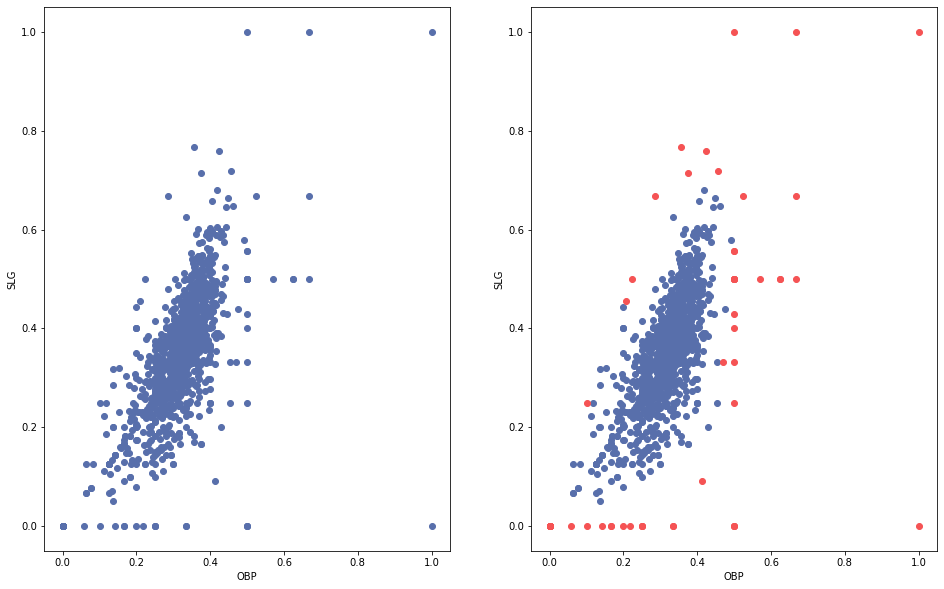

In [13]:
# DBSCAN을 이용한 이상치 제거
temp = outlier
plt.figure(figsize=(16,10))

plt.subplot(1,2,1)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.plot(temp['OBP'], temp['SLG'], 'o', color='#586fab');
plt.xlabel('OBP');
plt.ylabel('SLG');

plt.subplot(1,2,2)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
unique_labels = set(temp['outlier_1'])
colors = ['#586fab', '#f55354']
for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in temp['outlier_1']]
    plt.plot(temp['OBP'][sample_mask], temp['SLG'][sample_mask], 'o', color=color);
plt.xlabel('OBP');
plt.ylabel('SLG');
#plt.savefig('fig_anormaly_detection_1.png', dpi=300)

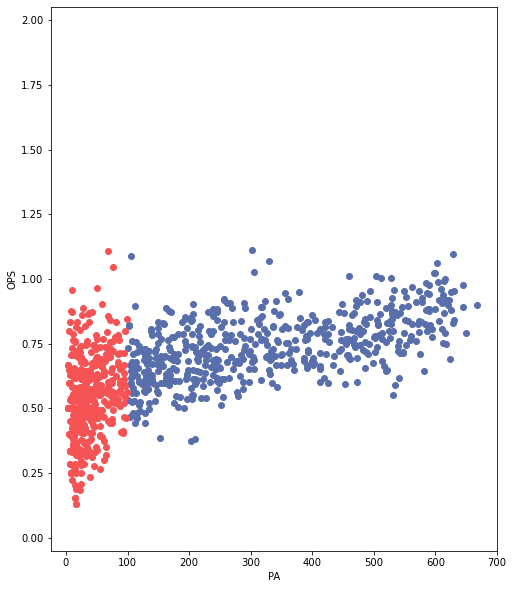

In [14]:
# 타석수 100 미만 제거
temp2 = temp[temp['outlier_1'] == 0]
plt.figure(figsize=(8,10))
plt.xlim(-25,700)
plt.ylim(-0.05,2.05)
unique_labels = set(temp2['outlier_2'])
colors = ['#586fab', '#f55354']
for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in temp2['outlier_2']]
    plt.plot(temp2['PA'].values[sample_mask], temp2['OPS'][sample_mask], 'o', color=color);

plt.xlabel('PA');
plt.ylabel('OPS');
#plt.savefig('fig_anormaly_detection_3.png', dpi=300)

(0.2312818025073858, 3.366619513733511e-08)

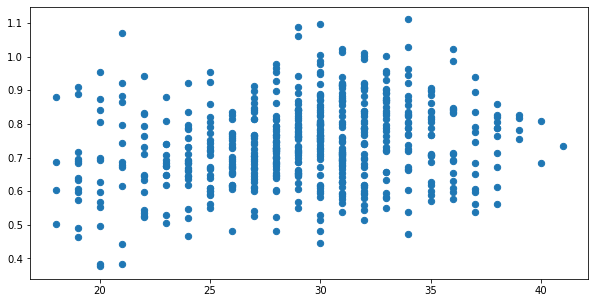

In [15]:
# 나이와 OPS 산점도
plt.figure(figsize=(10,5))
plt.scatter(normal['AGE_VA'], normal['OPS'],s=40)
#plt.savefig('fig1.png', dpi=300)
scipy.stats.pearsonr(normal['AGE_VA'], normal['OPS'])

(array([ 2.,  2.,  6.,  3., 16., 13.,  8.,  3.,  3.,  1.]),
 array([0.4445625 , 0.509826  , 0.57508949, 0.64035299, 0.70561648,
        0.77087998, 0.83614347, 0.90140697, 0.96667046, 1.03193396,
        1.09719745]),
 <BarContainer object of 10 artists>)

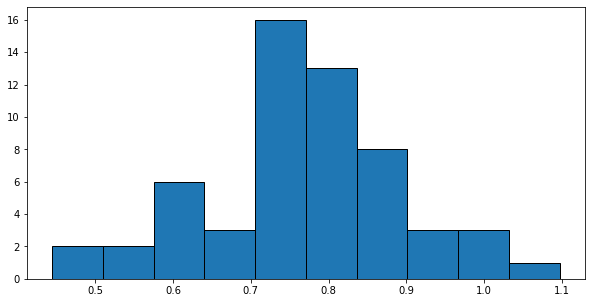

In [16]:
# 나이가 30세인 선수들의 OPS 분포
plt.figure(figsize=(10,5))
plt.hist(normal[normal['AGE_VA']==30]['OPS'], histtype='bar',edgecolor='k')
#plt.savefig('fig2.png', dpi=300)

{'whiskers': [<matplotlib.lines.Line2D at 0x17b1a3ba400>,
 'caps': [<matplotlib.lines.Line2D at 0x17b1a3baac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x17b1a3ba0a0>],
 'medians': [<matplotlib.lines.Line2D at 0x17b1a3c51c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x17b1a3c5520>],
 'means': []}

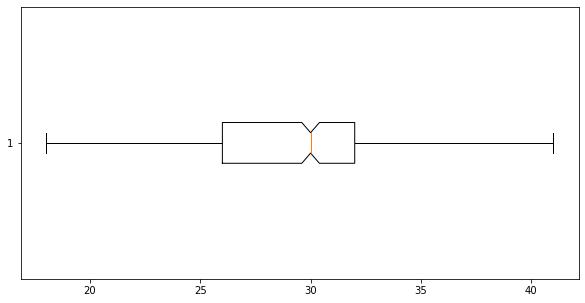

In [17]:
# 나이 분포(상자 그림)
plt.figure(figsize=(10,5))
plt.boxplot(normal['AGE_VA'], notch=True, whis=2.5, vert=False)
#plt.savefig('fig5.png', dpi=300)

In [18]:
age_grp(normal)
age_z(normal,['OBP','SLG'])

<ipython-input-6-0cef8dd72ea7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AGE_GRP'] = np.nan
<ipython-input-6-0cef8dd72ea7>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AGE_'+'Z_'+col] = np.nan
<ipython-input-6-0cef8dd72ea7>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

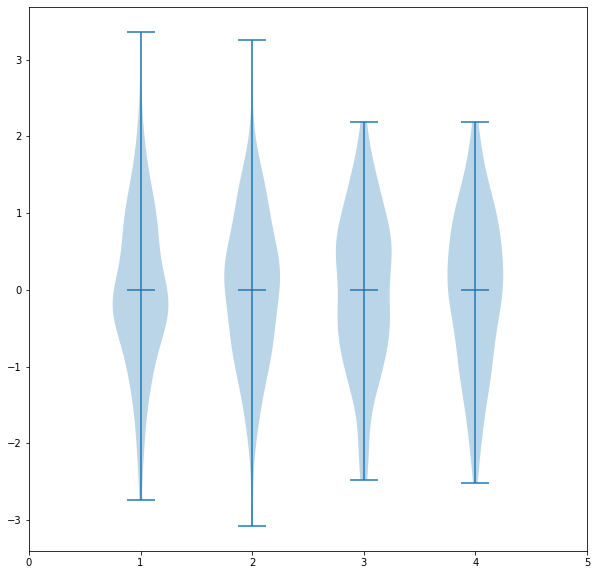

In [19]:
# 나이 그룹별 AGE_Z_OBP 분포
GRP_1 = normal[normal['AGE_GRP']==1]['AGE_Z_OBP'].values
GRP_2 = normal[normal['AGE_GRP']==2]['AGE_Z_OBP'].values
GRP_3 = normal[normal['AGE_GRP']==3]['AGE_Z_OBP'].values
GRP_4 = normal[normal['AGE_GRP']==4]['AGE_Z_OBP'].values

plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots()
violin = ax.violinplot([GRP_1, GRP_2, GRP_3, GRP_4],showmeans=True, positions=[1, 2, 3, 4])
ax.set_xticks([0, 1, 2, 3, 4, 5])
#ax.set_xlabel('AGE_GRP')
#ax.set_ylabel('OPS')

#plt.savefig('fig4.png', dpi=300)
plt.show()

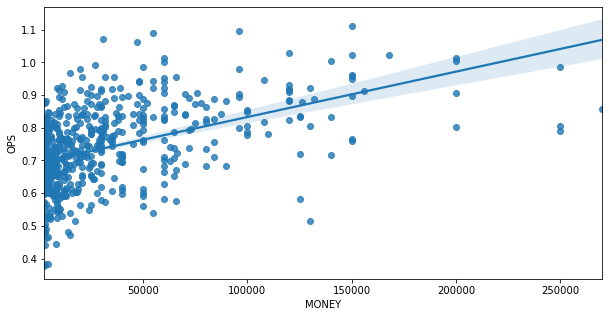

In [20]:
# 연봉과 OPS 상관관계
plt.rcParams["figure.figsize"] = (10, 5)
sns.regplot(x=normal['MONEY'], 

           y=normal['OPS'], 

           fit_reg=True)
plt.show()
#plt.savefig('fig7.png', dpi=300)

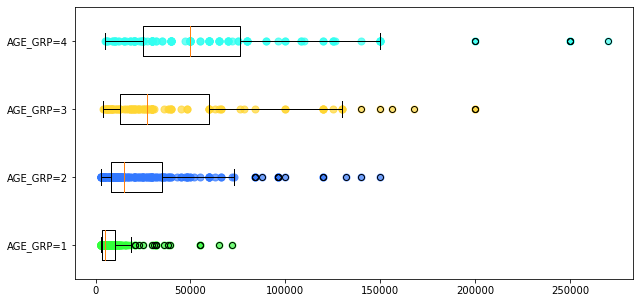

In [21]:
# 나이 그룹별 연봉 분포
GRP_1 = normal[normal['AGE_GRP']==1]['MONEY'].values
GRP_2 = normal[normal['AGE_GRP']==2]['MONEY'].values
GRP_3 = normal[normal['AGE_GRP']==3]['MONEY'].values
GRP_4 = normal[normal['AGE_GRP']==4]['MONEY'].values

namesA = ['AGE_GRP=1', 'AGE_GRP=2', 'AGE_GRP=3', 'AGE_GRP=4']
plt.rcParams["figure.figsize"] = (10, 5)
fig, ax = plt.subplots()
bplot1 = ax.boxplot([GRP_1,GRP_2,GRP_3,GRP_4], labels=namesA, notch=False, showmeans=False, vert=False)
palette = ['#33FF3B', '#3379FF', '#FFD633', '#33FFF1']
valsA = [GRP_1, GRP_2, GRP_3, GRP_4]
xsA = [np.full(GRP_1.shape,1), np.full(GRP_2.shape,2), np.full(GRP_3.shape,3), np.full(GRP_4.shape,4)]
for xA, valA, c in zip(xsA, valsA, palette):
    ax.scatter(valA, xA, alpha=0.7, color=c, s=50)
#plt.savefig('fig6.png', dpi=300)

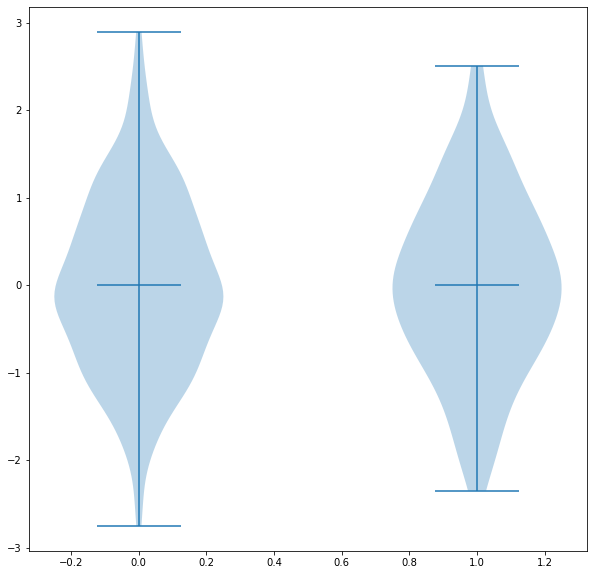

In [22]:
mon_grp(dt)
mon_z(dt,['OBP','SLG'])
# 연봉 그룹별 MON_Z_SLG
plt.rcParams["figure.figsize"] = (10, 10)
GRP_1 = normal[normal['MON_GRP']==0]['MON_Z_SLG'].values
GRP_2 = normal[normal['MON_GRP']==1]['MON_Z_SLG'].values

fig, ax = plt.subplots()
#ax.boxplot([GRP_1, GRP_2])
violin = ax.violinplot([GRP_1, GRP_2],showmeans=True, positions=[0, 1])
#ax.set_xlabel('MON_GRP')
#ax.set_ylabel('OPS')
#plt.savefig('fig10.png', dpi=300)
plt.show()

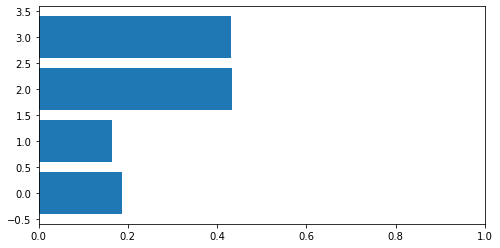

In [23]:
# 정은원 플레이 스타일
x = np.arange(4)
stats = ['BB%','KK%','OBP','SLG']
values = [0.186782, 0.163793 , 0.433526, 0.431]
plt.figure(figsize=(8,4))
plt.barh(x, values)
plt.xlim(0,1)
#plt.savefig('fig11.png', dpi=300)
plt.show()

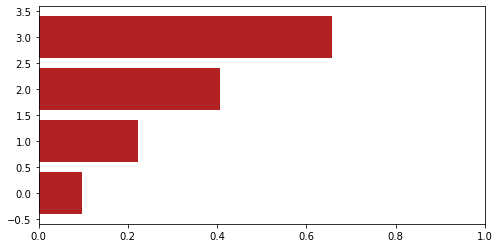

In [24]:
# 김재환 플레이 스타일
x = np.arange(4)
stats = ['BB%','KK%','OBP','SLG']
values = [0.098007, 0.222591 , 0.405316, 0.657]
plt.figure(figsize=(8,4))
plt.barh(x, values,color='firebrick')
plt.xlim(0,1)
#plt.savefig('fig12.png', dpi=300)
plt.show()

In [25]:
isop(normal)
isow(normal)

<ipython-input-6-0cef8dd72ea7>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsoP'] = df['SLG'] - df['BA']
<ipython-input-6-0cef8dd72ea7>:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsoW'] = (df['BB']) / (df['AB']+df['BB']+df['HP']+df['SF'])


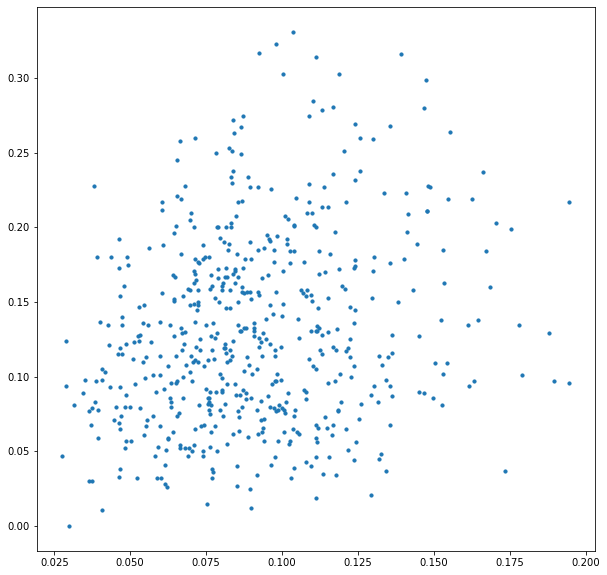

In [26]:
# IsoW, IsoP 산점도
plt.figure(figsize=(10,10))
plt.scatter(normal['IsoW'], normal['IsoP'],s=10)

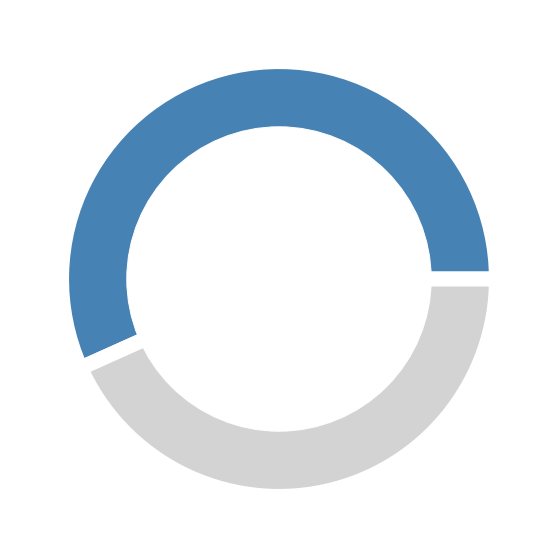

In [27]:
# 1년 전 성적 결측값 비율
values = [545, 416]
colors = ['steelblue','lightgray']
fig = plt.figure
cir = plt.Circle((0,0),0.7,color='white')
plt.pie(values, wedgeprops = {'linewidth':15, 'edgecolor':'white'},colors = colors)
p=plt.gcf()
p.gca().add_artist(cir)

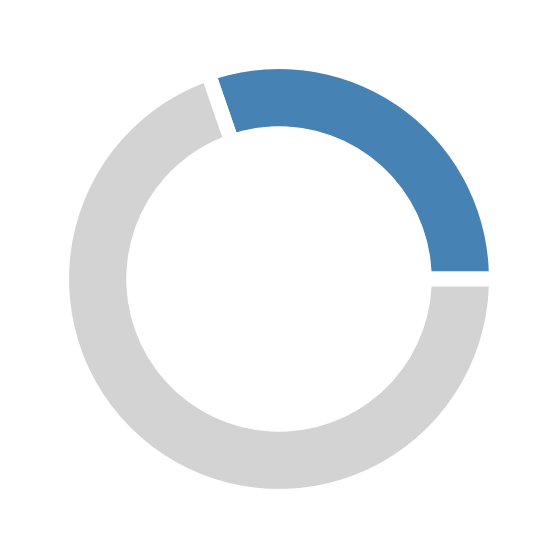

In [28]:
# 2년 전 성적 결측값 비율
values = [291, 670]
colors = ['steelblue','lightgray']
fig = plt.figure
cir = plt.Circle((0,0),0.7,color='white')
plt.pie(values, wedgeprops = {'linewidth':15, 'edgecolor':'white'},colors = colors)
p=plt.gcf()
p.gca().add_artist(cir)

In [29]:
lag_function(normal,['OBP','SLG'],1)
lag_function(normal,['OBP','SLG'],2)

<ipython-input-7-afc46e0d80a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(['PCODE','GYEAR'],inplace=True)
<ipython-input-7-afc46e0d80a3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag_' + col + '_' + str(shift)] = np.nan #빈 변수 생성


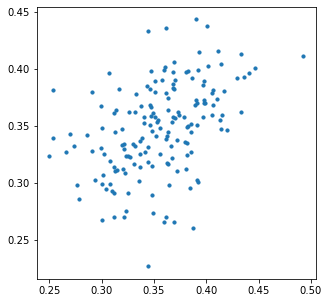

In [30]:
# 작년 OBP 와 올해 OBP의 상관관계
temp = normal[['OBP','lag_OBP_1','lag_OBP_2']].dropna()
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(temp['OBP'],temp['lag_OBP_1'],s=10)
#plt.savefig('fig_lag_why_1.png', dpi=300)

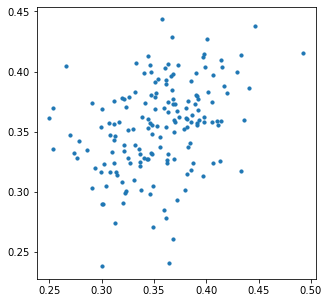

In [31]:
# 재작년 OBP 와 올해 OBP의 상관관계
temp = normal[['OBP','lag_OBP_1','lag_OBP_2']].dropna()
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(temp['OBP'],temp['lag_OBP_2'],s=10)
#plt.savefig('fig_lag_why_1.png', dpi=300)

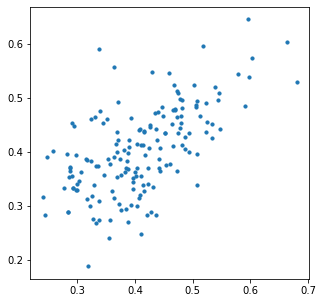

In [32]:
# 작년 SLG 와 올해 SLG의 상관관계
temp = normal[['SLG','lag_SLG_1','lag_SLG_2']].dropna()
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(temp['SLG'],temp['lag_SLG_1'],s=10)
#plt.savefig('fig_lag_why_1.png', dpi=300)

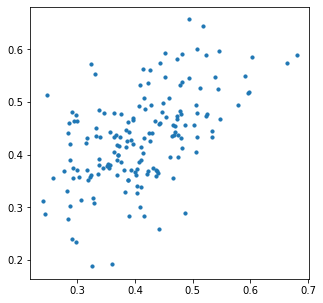

In [33]:
# 재작년 SLG 와 올해 SLG의 상관관계
temp = normal[['SLG','lag_SLG_1','lag_SLG_2']].dropna()
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(temp['SLG'],temp['lag_SLG_2'],s=10)
#plt.savefig('fig_lag_why_1.png', dpi=300)